In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [46]:
import numpy as np
import pandas as pd
from pandas.plotting import table
import os
from scipy import stats

In [3]:
from datetime import datetime
import datetime as dt
from dateutil.relativedelta import relativedelta

In [4]:
# Reflect Tables into SQLAlchemy ORM
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [7]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [12]:
#query = session.query(Measurement)
#measure_df = pd.read_sql_query(query.statement, session.get_bind())
#measure_df.head(200000)

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database.
last_measurement_data_point_tuple = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
(latest_date,) = last_measurement_data_point_tuple
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_date = latest_date.date()
date_year_ago = latest_date - relativedelta(years=1)


In [14]:
# Perform a query to retrieve the data and precipitation scores
last_year_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_year_ago).all()
#for record in data:
    #print(record)

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
climate_df = pd.DataFrame(last_year_data, columns = ['date', 'prcp'])
#drop nulls
climate_df = climate_df.dropna(how="any")
#set index
climate_df = climate_df.set_index("date")


In [16]:
# Sort the dataframe by date
climate_df = climate_df.sort_values(by=['date'])
climate_df.head(20000)

,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


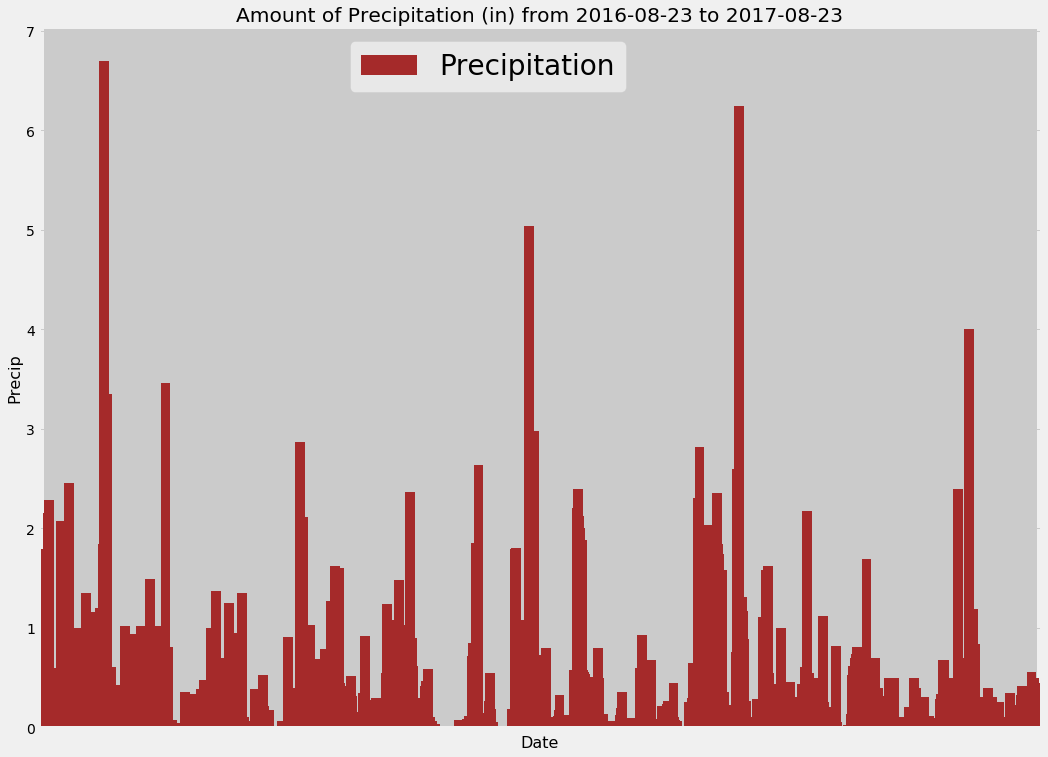

In [17]:
ax= climate_df.plot.bar(figsize=(16,12), width=20, color='brown')
ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("Precip", fontsize=16)
ax.set_xticklabels([])
ax.set_title(f"Amount of Precipitation (in) from {date_year_ago} to {latest_date}")
plt.legend(['Precipitation'], fontsize = 28)
ax.get_legend().set_bbox_to_anchor((0.6, 1))

plt.savefig("Images/CLIMATE.png")
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
stats = climate_df["prcp"].describe()
stats_df = pd.DataFrame(stats)
stats_df.rename(columns = {"prcp": "Precipitation"})

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
print(f"Number of stations available in this dataset.")
session.query(Station).group_by(Station.station).count()


Number of stations available in this dataset.


9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).\
order_by(func.count(Measurement.date).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# Grab the most active station
print(f"The most active station is.")
most_active_station=session.query(Measurement.station).group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).first()
most_active_station_id = most_active_station[0]
most_active_station_id

The most active station is.


'USC00519281'

In [22]:
#calculate the lowest, highest, avg temperature recorded for most active station
print(f"The most active station ID with the lowest, highest, and avg temp recorded.")

most_active = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == most_active_station_id).all()

for lowest_temp, highest_temp, avg_temp in most_active:
    print(f"The lowest temperature recorded at {most_active_station_id} was {lowest_temp}.")
    print(f"The highest temperature recorded at {most_active_station_id} was {highest_temp}.")
    print(f"The average temperature recorded at {most_active_station_id} was {avg_temp}.")
temperature_df = pd.DataFrame({
    "Lowest Temperature": lowest_temp,
    "Highest Temperature": highest_temp,
    "Average Temperature": avg_temp
}, index=[0])

temperature_df

The most active station ID with the lowest, highest, and avg temp recorded.
The lowest temperature recorded at USC00519281 was 54.0.
The highest temperature recorded at USC00519281 was 85.0.
The average temperature recorded at USC00519281 was 71.66378066378067.


,Lowest Temperature,Highest Temperature,Average Temperature
0,54.0,85.0,71.663781


In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_observation = session.query(Measurement.date).\
order_by(Measurement.date.desc()).\
filter(Measurement.station == most_active_station_id).first()

(latest_date,) = temp_observation
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_date = latest_date.date()
date_year_ago = latest_date - relativedelta(years=1)

last_year_data = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.station == most_active_station_id).\
filter(Measurement.date >= date_year_ago).all()

last_year_data_df = pd.DataFrame(last_year_data, columns=['date', 'tobs'])

last_year_data_df

,date,tobs
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0
...,...,...
352,2017-08-14,77.0
353,2017-08-15,77.0
354,2017-08-16,76.0
355,2017-08-17,76.0


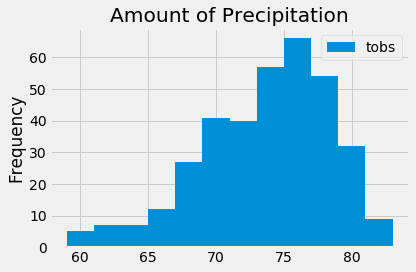

In [51]:
#create the plot
df = pd.DataFrame(last_year_data_df, columns=['tobs'])
df.plot.hist(bins=12)
plt.title(f"Amount of Precipitation")
plt.tight_layout()

plt.savefig("Images/Frequency.png")
plt.show()



## Bonus Challenge Assignment

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = dt.date(2017, 5 ,10)
trip_end_date = dt.date(2017, 5 ,16)
print(calc_temps(trip_start_date, trip_end_date))
temps_list = calc_temps(trip_start_date, trip_end_date)

[(70.0, 75.38461538461539, 79.0)]


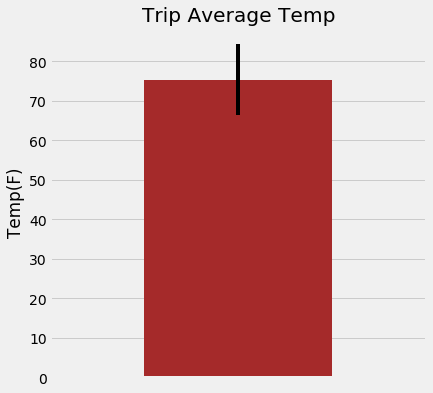

In [52]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# create the dataframe
df = pd.DataFrame(temps_list, columns=["t_min", "t_avg", "t_max"])

# plot the average temp 
plt.figure(figsize=(6,6))
ax=df["t_avg"].plot.bar(yerr=(df["t_max"]-df["t_min"]), color="brown")
plt.title("Trip Average Temp")
plt.ylabel("Temp(F)")
ax.axes.get_xaxis().set_visible(False)


# Save the plot

plt.savefig("Images/avg_temp.png")
plt.show()

In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
total_rainfall_per_weather_station = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= trip_start_date).\
    filter(Measurement.date <= trip_end_date).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
    
rainfall_df = pd.DataFrame(total_rainfall_per_weather_station, columns=["Station", "Name", "Latitude", "Longitude", "Elevation", "Sum/Total Precipitation"])

rainfall_df



,Station,Name,Latitude,Longitude,Elevation,Sum/Total Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.09
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.75
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.30
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.12
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.07
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.05


Temperature Analysis 1

In [29]:
# Identify the average temperature in June at all stations across all available years in the dataset. 
avg_june_temp_list = session.query(func.avg(Measurement.tobs)).\
                filter(func.strftime("%m", Measurement.date) == "06").all()

average_june_temp = list(np.ravel(avg_june_temp_list))[0]

# Identify the average temperature in December at all stations across all available years in the dataset. 
avg_dec_temp_list = session.query(func.avg(Measurement.tobs)).\
                filter(func.strftime("%m", Measurement.date) == "12").all()

average_dec_temp = list(np.ravel(avg_dec_temp_list))[0]

print(f"The average temperature in June at all stations across all available years in the dataset is {average_june_temp} F.")
print(f"The average temperature in December at all stations across all available years in the dataset is {average_dec_temp} F.")

The average temperature in June at all stations across all available years in the dataset is 74.94411764705882 F.
The average temperature in December at all stations across all available years in the dataset is 71.04152933421226 F.


In [30]:
june_temp_list = session.query(Measurement.tobs).\
                filter(func.strftime("%m", Measurement.date) == "06").all()

june_tmp_list = list(np.ravel(june_temp_list))

# Remove nulls (if any)
clean_june_tmp_list = []
for temp in june_tmp_list: 
    if temp != None : 
        clean_june_tmp_list.append(temp)

dec_temp_list = session.query(Measurement.tobs).\
                filter(func.strftime("%m", Measurement.date) == "12").all()

dec_tmp_list = list(np.ravel(dec_temp_list))

# Remove nulls (if any)
clean_dec_tmp_list = []
for temp in dec_tmp_list: 
    if temp != None : 
        clean_dec_tmp_list.append(temp)

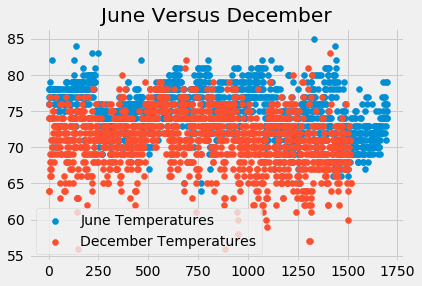

In [31]:
# Scatter Plot of Data
plt.subplot(1, 1, 1)
plt.scatter(range(len(clean_june_tmp_list)), clean_june_tmp_list, label="June Temperatures")
plt.scatter(range(len(clean_dec_tmp_list)), clean_dec_tmp_list, label="December Temperatures")
plt.legend()
plt.title("June Versus December")
plt.savefig("Images/June vs December Scatter Plot.png")

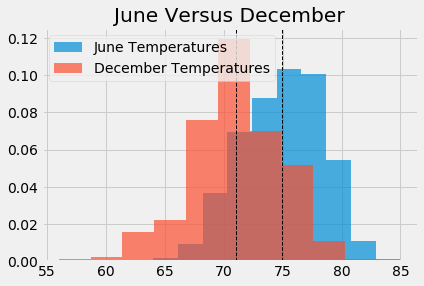

In [32]:
# Histogram Plot of Data
plt.subplot(1, 1, 1)
plt.hist(clean_june_tmp_list, 10, density=True, alpha=0.7, label="June Temperatures")
plt.hist(clean_dec_tmp_list, 10, density=True, alpha=0.7, label="December Temperatures")
plt.axvline(np.mean(clean_june_tmp_list), color='k', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(clean_dec_tmp_list), color='k', linestyle='dashed', linewidth=1)
plt.legend()

plt.title("June Versus December")
plt.savefig("Images/june_dec_histogram.png")

In [57]:
stats.ttest_ind(june_tmp_list, dec_tmp_list, equal_var=False)
# It is a statistically significant difference in means (p-value of less than 0.05).
# Very small value - means of these two populations are significantly different.
# lower probability that the difference is random.
# Reject the null hypothesis.
# null hypothesis - there is no meaningful difference between the temperature in June and December in Hawaii.

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

In [58]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-09")

[(58.0, 67.9298245614035, 78.0)]

In [59]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = dt.datetime.strftime(trip_start_date, "%m-%d")
end = dt.datetime.strftime(trip_end_date, "%m-%d")

# Use the start and end date to create a range of dates
start = dt.datetime.strptime(start, "%m-%d")
end = dt.datetime.strptime(end, "%m-%d")

#use the start and end to create range 
date_array = (start + dt.timedelta(days=x) for x in range(0, ((end-start).days)+1))

# Stip off the year and save a list of %m-%d strings
date_list = []
for date_object in date_array:
    string_date = date_object.strftime("%m-%d")
    date_list.append(string_date)

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals_list = []
for date in date_list:
    daily_normals_list.append(daily_normals(date))

min_temp_list = []
avg_temp_list = []
max_temp_list = []
print(daily_normals_list)
for daily_normals_item in daily_normals_list:
    for min_temp, avg_temp, max_temp in daily_normals_item:
        min_temp_list.append(min_temp)
        avg_temp_list.append(avg_temp)
        max_temp_list.append(max_temp)

[[(64.0, 73.3157894736842, 78.0)], [(65.0, 73.61111111111111, 79.0)], [(65.0, 73.13793103448276, 79.0)], [(67.0, 73.14285714285714, 79.0)], [(63.0, 73.89285714285714, 80.0)], [(63.0, 73.69090909090909, 79.0)], [(68.0, 74.37931034482759, 80.0)]]


In [60]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame({
    "trip_dates": date_list,
    "tmin": min_temp_list,
    "tavg": avg_temp_list,
    "tmax": max_temp_list
})
daily_normals_df = daily_normals_df.set_index("trip_dates")
daily_normals_df

,tmin,tavg,tmax
trip_dates,,,
05-10,64.0,73.315789,78.0
05-11,65.0,73.611111,79.0
05-12,65.0,73.137931,79.0
05-13,67.0,73.142857,79.0
05-14,63.0,73.892857,80.0
05-15,63.0,73.690909,79.0
05-16,68.0,74.379310,80.0


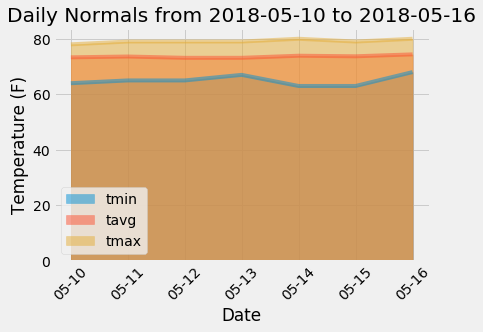

In [61]:
# Plot the daily normals as an area plot with `stacked=False`
ax = daily_normals_df.plot.area(stacked=False)
trip_start = trip_start_date.replace(year = trip_start_date.year + 1)
trip_end = trip_end_date.replace(year = trip_end_date.year + 1)
ax.set_title(f"Daily Normals from {trip_start} to {trip_end}")
plt.xticks(rotation=45)
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (F)")
plt.savefig("Images/daily_normals.png")
plt.show()